In [1]:
from langchain_openai import ChatOpenAI

model="gpt-3.5-turbo"
# model="gpt-4o"
# model="gpt-4-turbo-2024-04-09"

llm = ChatOpenAI(model=model)
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x0000023D918E4A00>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x0000023D918E6110>, openai_api_key=SecretStr('**********'), openai_proxy='')

## Tools

In [2]:
from langchain_core.tools import tool

# @tool
# def lookup_policy(query: str) -> str:
#     """Consult the company policies to check whether certain options are permitted.
#     Use this before making any flight changes performing other 'write' events."""
#     docs = retriever.query(query, k=2)
#     return "\n\n".join([doc["page_content"] for doc in docs])

@tool
def fetch_user_information():
    """
    Fetch user information
    This function retrieves user information from the database
    """
    temp_info = """
    name: nadle
    사용자 이름: nadle
    구매 일자: 2024.06.18
    구매 상품:
    무지개 백설기 (12,000원) 3개
    개별 모듬팩 (5,000원) 2개
    떡케익 (25,000원) 1개
    총 구매 금액: 71,000원
    """
    return temp_info


# class VectorStoreRetriever:
#     def __init__(self, docs: list, vectors: list, oai_client):
#         self._arr = np.array(vectors)
#         self._docs = docs
#         self._client = oai_client

#     @classmethod
#     def from_docs(cls, docs, oai_client):
#         embeddings = oai_client.embeddings.create(
#             model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]
#         )
#         vectors = [emb.embedding for emb in embeddings.data]
#         return cls(docs, vectors, oai_client)

#     def query(self, query: str, k: int = 5) -> list[dict]:
#         embed = self._client.embeddings.create(
#             model="text-embedding-3-small", input=[query]
#         )
#         # "@" is just a matrix multiplication in python
#         scores = np.array(embed.data[0].embedding) @ self._arr.T
#         top_k_idx = np.argpartition(scores, -k)[-k:]
#         top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
#         return [
#             {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
#         ]


# retriever = VectorStoreRetriever.from_docs(docs, openai.Client())

@tool
def lookup_policy(message: str):
    """
    Consult the company policies regarding product exchanges and refunds.
    Use this function to check the company policies before proceeding with an exchange or refund.
    """
    temp_info = """
    교환/반품 안내

    제품수령 후 7일 이내 교환/반품 가능합니다.
    상품 하자 이외의 사이즈/색상 변경은 단순 변심에 의한 교환/반품이 불가능합니다.
    이미지를 보시는 기기의 성상차이나 색상, 사이즈 등 개인의 성호도에 따라 달리 느껴질 수 있습니다.
    
    교환/반품이 불가능한 경우
    제품의 라벨이나 신발박스가 훼손된 경우
    수제화 등 주문제작 상품의 경우
    오염물이 다르나 오염이 확실한 반품의 경우
    기간내에 상품을 보내주시고 교환/반품이 어려울정도로 훼손되어 보내주셨을 경우
    """
    return temp_info


@tool
def order():
    """
    Places a new order.
    This function processes a new order request and confirms
    """
    return "주문 완료"

@tool
def change_order():
    """
    Modifies an existing order.
    This function allows the user to change details of an existing
    """
    return "주문 변경 완료"

@tool
def cancel_order():
    """
    Cancels an existing order.
    This function processes the cancellation of an existing order
    """
    return "주문 취소 완료"

@tool
def view_order():
    """
    Views the details of a specific order.
    This function retrieves and returns the details of an order.
    """
    return "주문 조회 완료"

@tool
def view_change_order():
    """
    Views the details of a modified order.
    This function retrieves and returns the details of the changes made to an order.
    """
    return "주문 변경 조회 완료"

@tool
def view_cancel_order():
    """
    Views the details of a canceled order.
    This function retrieves and returns the details of a canceled order.
    """
    return "주문 취소 조회 완료"

## Utilities


In [3]:
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableLambda


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    # print("event\n", event) # ts
    current_state = event["dialog_state"]
    if current_state:
        print("Currently in: ", current_state)
    message = event.get("messages") 
    # print("message\n", message) # ts
    #  [HumanMessage(content='주문 내역 알려줘', id='2bdd1a07-d196-4612-b435-fe2086312fa1')]
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            # msg_repr = message.pretty_repr(html=True)
            msg_repr = message.pretty_repr()
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] +  " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# Part1

## State

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [8]:
from typing import Annotated, Literal, Optional, List
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    dialog_state: Annotated[
            list[
                Literal[
                    "assistant",
                    "query",
                    "requset",
                ]
            ],
            update_dialog_stack,
        ]

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatMessagePromptTemplate, MessagesPlaceholder
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: RunnableConfig):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            customer_id = configuration.get("customer_id", None)
            state = {**state, "user_info": customer_id}
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


In [10]:
from datetime import datetime

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder



primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        # ("placeholder", "{messages}"),
        MessagesPlaceholder(variable_name="messages"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    order,
    change_order,
    cancel_order,
    view_order,
    view_change_order,
    view_cancel_order,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

## Define Graph

In [15]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)

builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

NameError: name 'create_tool_node_with_fallback' is not defined

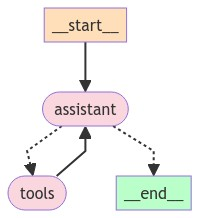

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import uuid 

thread_id = str(uuid.uuid4())
thread_id

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "customer_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}
config

{'configurable': {'customer_id': '1089',
  'thread_id': '81e51453-6ea1-495e-a6b6-b2244f947b49'}}

In [ ]:
# ts

events = part_1_graph.stream(
        {"messages": ("user", "주문하고 싶어요")}, config, stream_mode="values"
        )
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

주문하고 싶어요
================================== Ai Message ==================================
Tool Calls:
  order (call_3hC1aPizHEWQA4eWVYBBJbbS)
 Call ID: call_3hC1aPizHEWQA4eWVYBBJbbS
  Args:
================================= Tool Message =================================
Name: order

주문 완료
================================== Ai Message ==================================

주문이 완료되었습니다! 추가로 도움이 필요하시거나 다른 질문이 있으시면 언제든지 알려주세요.


In [ ]:
events = part_1_graph.stream(
        {"messages": ("user", "주문하고 싶어요")}, config, stream_mode="values"
        )
for event in events:
    print("="*77)
    print(event)
    print(event.keys())

{'messages': [HumanMessage(content='주문하고 싶어요', id='79e8f598-23a6-4bfb-8256-3f27451566f8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rG5EFwoetHpt1IgAZDWioHkr', 'function': {'arguments': '{}', 'name': 'order'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 302, 'total_tokens': 311}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6573cbcd-b5c7-40bc-850b-fc9c148c37fe-0', tool_calls=[{'name': 'order', 'args': {}, 'id': 'call_rG5EFwoetHpt1IgAZDWioHkr'}], usage_metadata={'input_tokens': 302, 'output_tokens': 9, 'total_tokens': 311}), ToolMessage(content='주문 완료', name='order', id='8c371e5e-b915-439f-b774-feae9fcc3848', tool_call_id='call_rG5EFwoetHpt1IgAZDWioHkr'), AIMessage(content='주문이 성공적으로 완료되었습니다. 도와드릴 다른 사항이 있나요?', response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 323, 'total_tokens': 355}, 'model_name': 'gpt-3.5

In [ ]:
_printed = set()
while True:
    customer_message = input("메시지를 입력하세요 :)")
    events = part_1_graph.stream(
        {"messages": ("user", customer_message)}, config, stream_mode="values"
        )
    for event in events:
        _print_event(event, _print_event)

KeyError: 'dialog_state'

State에 dialog_state 속성 추가 후 실행

In [ ]:
_printed = set()
while True:
    customer_message = input("메시지를 입력하세요 :)")
    events = part_1_graph.stream(
        {"messages": ("user", customer_message)}, config, stream_mode="values"
        )
    for event in events:
        _print_event(event, _print_event) # _printed 입력 해야할 곳에 _print_event 입력해서 발생한 오류 

event
 {'messages': [HumanMessage(content='주문 내역 알려줘', id='2bdd1a07-d196-4612-b435-fe2086312fa1')], 'dialog_state': []}
message
 [HumanMessage(content='주문 내역 알려줘', id='2bdd1a07-d196-4612-b435-fe2086312fa1')]


TypeError: argument of type 'function' is not iterable

In [ ]:
from langchain_core.messages import HumanMessage

HumanMessage(content='주문 내역 알려줘', id='2bdd1a07-d196-4612-b435-fe2086312fa1').id
HumanMessage(content='주문 내역 알려줘', id='2bdd1a07-d196-4612-b435-fe2086312fa1').pretty_print()

================================ Human Message =================================

주문 내역 알려줘


In [ ]:
_printed = set()
while True:
    customer_message = input("메시지를 입력하세요 :)")
    ㅑ
    events = part_1_graph.stream(
        {"messages": ("user", customer_message)}, config, stream_mode="values"
        )
    for event in events:
        _print_event(event, _printed)

event
 {'messages': [HumanMessage(content='주문 내역 알려줘', id='9b3e40c7-99e2-4cc9-8eae-9be6478de3ac')], 'dialog_state': []}
message
 [HumanMessage(content='주문 내역 알려줘', id='9b3e40c7-99e2-4cc9-8eae-9be6478de3ac')]
================================ Human Message =================================

주문 내역 알려줘
event
 {'messages': [HumanMessage(content='주문 내역 알려줘', id='9b3e40c7-99e2-4cc9-8eae-9be6478de3ac'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aluD333MKy6DYIwS2xWIvjW3', 'function': {'arguments': '{}', 'name': 'view_order'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 305, 'total_tokens': 315}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3865f522-684e-46d3-866a-05c4f5c42465-0', tool_calls=[{'name': 'view_order', 'args': {}, 'id': 'call_aluD333MKy6DYIwS2xWIvjW3'}], usage_metadata={'input_tokens': 305, 'output_tokens': 10, 'total_tokens': 315

: 

: 

# Part2

## State & Assistant

In [38]:
from typing import Annotated
from datetime import datetime

# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
# from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [39]:
assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant "
            "Use the provided tools to search for products available in the store," 
            "handle order-related queries (such as order status, changes, and cancellations),"
            "manage order-related requests (such as placing, changing, and canceling orders),"
            "and respond to the user's questions accurately"
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        # ("placeholder", "{messages}"),
        MessagesPlaceholder(variable_name="messages")
    ]
).partial(time=datetime.now())

part_2_tools = [
    view_order,
    view_change_order,
    view_cancel_order,
    order,
    change_order,
    cancel_order,
]
part_2_assistant_runnable = assistant_prompt | llm.bind_tools(part_2_tools)

## Define Graph

핵심은 interrupt_before=["tools"] 부분

In [40]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

def user_info(state: State):
    return {"user_info": fetch_user_information.invoke({})}

builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")
builder.add_node("assistant", Assistant(part_2_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_2_tools))
builder.add_edge("fetch_user_info", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = SqliteSaver.from_conn_string(":memory:")
part_2_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["tools"],
)

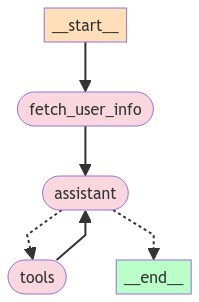

In [41]:
from IPython.display import Image, display

try:
    display(Image(part_2_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Example Conversation

In [47]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "customer_id": "1089",
        "thread_id": thread_id,
    }
}
config 

{'configurable': {'customer_id': '1089',
  'thread_id': '09937448-28e4-4101-83fd-92a7dd0d795f'}}

In [48]:
# _printed = set()

while True:
    customer_message = input("메시지 입력: ")
    if customer_message == "y":
        break
    events = part_2_graph.stream(
        {"messages": ("user", customer_message)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
            snapshot = part_2_graph.get_state(config)

event
 {'messages': [HumanMessage(content='주문 내역 알고 싶어', id='bbf9bbba-dba8-47e8-b933-a303cecb4a0a')]}
message
 [HumanMessage(content='주문 내역 알고 싶어', id='bbf9bbba-dba8-47e8-b933-a303cecb4a0a')]
================================ Human Message =================================

주문 내역 알고 싶어
event
 {'messages': [HumanMessage(content='주문 내역 알고 싶어', id='bbf9bbba-dba8-47e8-b933-a303cecb4a0a')], 'user_info': '\n    name: nadle\n    사용자 이름: nadle\n    구매 일자: 2024.06.18\n    구매 상품:\n    무지개 백설기 (12,000원) 3개\n    개별 모듬팩 (5,000원) 2개\n    떡케익 (25,000원) 1개\n    총 구매 금액: 71,000원\n    '}
message
 [HumanMessage(content='주문 내역 알고 싶어', id='bbf9bbba-dba8-47e8-b933-a303cecb4a0a')]
event
 {'messages': [HumanMessage(content='주문 내역 알고 싶어', id='bbf9bbba-dba8-47e8-b933-a303cecb4a0a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UeJT4pyvNB3QFTMrYZYG6vaM', 'function': {'arguments': '{}', 'name': 'view_order'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 10,

ValueError: No tasks to run in graph.

In [32]:
while True:
    customer_message = input("메시지 입력: ")
    if customer_message == "y":
        break
    events = part_2_graph.stream(
        {"messages": ("user", customer_message)}, config, stream_mode="values"
    )
    # for event in events:
    #     _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
            snapshot = part_2_graph.get_state(config)

In [43]:
events = part_2_graph.stream(
        {"messages": ("user", "주문 내역 알고 싶어")}, config, stream_mode="values"
    )

for event in events:
    print(event)

{'messages': [HumanMessage(content='주문 내역 알고 싶어', id='7f1de43e-3336-47a9-9cc0-965d90a929d3')]}
{'messages': [HumanMessage(content='주문 내역 알고 싶어', id='7f1de43e-3336-47a9-9cc0-965d90a929d3')], 'user_info': '\n    name: nadle\n    사용자 이름: nadle\n    구매 일자: 2024.06.18\n    구매 상품:\n    무지개 백설기 (12,000원) 3개\n    개별 모듬팩 (5,000원) 2개\n    떡케익 (25,000원) 1개\n    총 구매 금액: 71,000원\n    '}
{'messages': [HumanMessage(content='주문 내역 알고 싶어', id='7f1de43e-3336-47a9-9cc0-965d90a929d3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_K7yixYiQU4rQGCrtBItoenK3', 'function': {'arguments': '{}', 'name': 'view_order'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 409, 'total_tokens': 419}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ccd343d5-dad1-4a94-8880-a42896d5d6d6-0', tool_calls=[{'name': 'view_order', 'args': {}, 'id': 'call_K7yixYiQU4rQGCrtBItoenK3'}], usag

In [36]:
customer_message = input("메시지 입력")
events = part_2_graph.stream(
        {"messages": ("user", customer_message)}, config, stream_mode="values"
    )
for event in events:
    print(event)

{'messages': [HumanMessage(content='y', id='52b1efd2-0b37-4885-ad40-e674621d6e47'), HumanMessage(content='주문 내역 알고 싶어', id='f55c4b99-cc46-44fb-9027-c4528c860167'), HumanMessage(content='주문 내역을 알고 싶어', id='c0e9b511-2635-4910-8f1c-d9fea1117ef3')], 'dialog_state': []}


InvalidUpdateError: Must write to at least one of ['messages', 'dialog_state']

# Practical

## State

In [27]:
from typing import Annotated, Literal, Optional
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
            list[
                Literal[
                    "assistant",
                    "query",
                    "requset",
                ]
            ],
            update_dialog_stack,
        ]

In [19]:
# update_dialog_stack 없어도 되는지 실험 위한 코드

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: List[str]

## Assistant

In [28]:
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [29]:
from langchain_core.pydantic_v1 import BaseModel, Field

class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to use the tool to place a new order.",
            },
        }


## Create Assistant

In [30]:

from datetime import datetime
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


# order inquiry assistant
order_inquiry_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling order queries. "
            "The primary assistant delegates work to you whenever the user needs help with their orders. "
            "Confirm the order details with the customer and inform them of any additional information. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            "\n\nCurrent user order information:\n<Orders>\n{user_info}\n</Orders>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
).partial(time=datetime.now())

inquiry_tools = [view_order, view_change_order, view_cancel_order]
order_inquiry_runnable = order_inquiry_prompt | llm.bind_tools(   
    inquiry_tools + [CompleteOrEscalate]
)
order_inquiry_runnable

# order request assistant
order_request_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling order queries. "
            "The primary assistant delegates work to you whenever the user needs help with their orders. "
            "Perform the order placement, modification, or cancellation as requested by the customer and inform them of any additional information or fees."
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            "\n\nCurrent user order information:\n<Orders>\n{user_info}\n</Orders>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
).partial(time=datetime.now())

request_tools = [order, change_order, cancel_order]
order_request_runnable = order_request_prompt | llm.bind_tools(   
    request_tools + [CompleteOrEscalate]
)
order_request_runnable

# Primary Assistant
class ToOrderInquiryAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle order queries."""

    order_id: int = Field(description="The ID of the order to query.")
    request: str = Field(description="Any necessary follow-up questions the querying assistant should clarify before proceeding.")

class ToOrderRequestAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle order placements, modifications, or cancellations."""

    order_id: int = Field(description="The ID of the order to update.")
    action: str = Field(description="The action to perform: 'order', 'change_order', 'cancel_order'.")
    request: str = Field(description="Any additional information or requests from the user regarding the order.")


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant "
            "Your primary role is to search for company policies to answer customer queries. "
            "If a customer requests order-related inquiries (such as checking past orders, viewing order changes, or viewing order cancellations)"
            "or order-related requests (such as placing an order, changing an order, or canceling an order), delegate the task to the appropriate specialized assistant."
            "Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        # ("placeholder", "{messages}"),
        MessagesPlaceholder(variable_name="messages")
    ]
).partial(time=datetime.now())

primary_assistant_tools = [
    lookup_policy,
]
primary_assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToOrderInquiryAssistant,
        ToOrderRequestAssistant,
        ]
    )

## Utilities

In [31]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and action like order lookup and order request is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

## Define Graph

In [32]:
from typing import Literal

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")

# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }

builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")


# order inquiry assistant
builder.add_node(
    "enter_order_inquiry",
    create_entry_node("Order Inqury Assistant", "order_inquiry"),
)
builder.add_node("order_inquiry", Assistant(order_inquiry_runnable))
builder.add_edge("enter_order_inquiry", "order_inquiry")
builder.add_node(
    "inquiry_tools",
    create_tool_node_with_fallback(inquiry_tools),
)
builder.add_edge("inquiry_tools", "order_inquiry")

def route_order_inquiry(
        state: State,
) -> Literal[
    "inquiry_tools",
    "leave_skill",
    "__end__"
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    return "inquiry_tools"

builder.add_conditional_edges("order_inquiry", route_order_inquiry)


# order request assistant
builder.add_node(
    "enter_order_request",
    create_entry_node("Order Request Assistant", "order_request"),
)
builder.add_node("order_request", Assistant(order_request_runnable))
builder.add_edge("enter_order_request", "order_request")
builder.add_node(
    "request_tools",
    create_tool_node_with_fallback(request_tools),
)
builder.add_edge("request_tools", "order_request")

def route_order_inquiry(
        state: State,
) -> Literal[
    "request_tools",
    "leave_skill",
    "__end__"
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    return "request_tools"

builder.add_conditional_edges("order_request", route_order_inquiry)


# Primary assistant
builder.add_node("primary_assistant", Assistant(primary_assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)
builder.add_edge("primary_assistant_tools", "primary_assistant")

def route_primary_assistant(
        state: State,
) -> Literal[
    "primary_assistant_tools",
    "enter_order_inquiry",
    "enter_order_request",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToOrderInquiryAssistant.__name__:
            return "enter_order_inquiry"
        elif tool_calls[0]["name"] == ToOrderRequestAssistant.__name__:
            return "enter_order_request"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")

builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_order_inquiry": "enter_order_inquiry",
        "enter_order_request": "enter_order_request",
        "primary_assistant_tools": "primary_assistant_tools",
        END: END,
    },
)


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "order_inquiry",
    "order_request",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]

builder.add_conditional_edges("fetch_user_info", route_to_workflow)
# builder.add_conditional_edges(
#     "fetch_user_info", 
#     route_to_workflow,
#     # END 경우는 고려 필요 없겠지? dialog_state[-1] 있단 말이니. enter_order_inquiry가 아닌 order_inquiry 맞나?
#     {
#         "primary_assistant": "primary_assistant",
#         "order_inquiry": "order_inquiry",
#         "order_request": "order_request",
#      },
#     )

memory = SqliteSaver.from_conn_string(":memory:")
orderbot_graph = builder.compile(
    checkpointer=memory,
    interrupt_before=[
        "request_tools",
    ],
)

builder.add_conditional_edges 밑에 경로 매핑하니 아래 셀 실행만 되고 그래프 그려지지 않았음

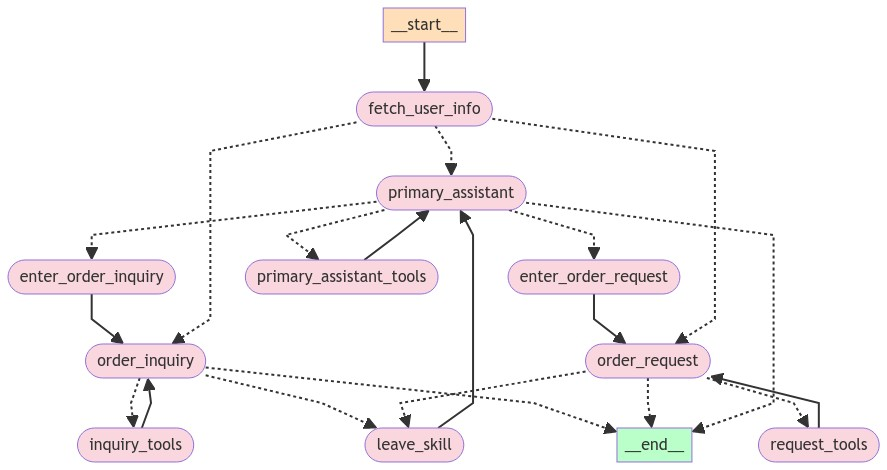

In [18]:
from IPython.display import Image, display

try:
    display(Image(orderbot_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Conversation

## 1

In [44]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
while True:
    question = input("메시지를 입력하세요~")
    if question == "stop":
        break
    events = orderbot_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = orderbot_graph.get_state(config)
    print("snapshot\n", snapshot)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = orderbot_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = orderbot_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = orderbot_graph.get_state(config)

event
 {'messages': [HumanMessage(content='주문 변경 내역을 알고 싶어', id='4d3bb3ae-7089-46d6-858e-c4bd2c28ca01')], 'dialog_state': []}
message
 [HumanMessage(content='주문 변경 내역을 알고 싶어', id='4d3bb3ae-7089-46d6-858e-c4bd2c28ca01')]
================================ Human Message =================================

주문 변경 내역을 알고 싶어
event
 {'messages': [HumanMessage(content='주문 변경 내역을 알고 싶어', id='4d3bb3ae-7089-46d6-858e-c4bd2c28ca01')], 'user_info': '\n    name: nadle\n    사용자 이름: nadle\n    구매 일자: 2024.06.18\n    구매 상품:\n    무지개 백설기 (12,000원) 3개\n    개별 모듬팩 (5,000원) 2개\n    떡케익 (25,000원) 1개\n    총 구매 금액: 71,000원\n    ', 'dialog_state': []}
message
 [HumanMessage(content='주문 변경 내역을 알고 싶어', id='4d3bb3ae-7089-46d6-858e-c4bd2c28ca01')]
event
 {'messages': [HumanMessage(content='주문 변경 내역을 알고 싶어', id='4d3bb3ae-7089-46d6-858e-c4bd2c28ca01'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T72ZrvhOczlh9mHdalunAb4H', 'function': {'arguments': '{"order_id":202427,"request":"Please provide t

KeyError: 'order inquiry status'

## 2


create_entry_node에 입력하는 status 명칭을 노드와 일치되게 수정

In [46]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
while True:
    question = input("메시지를 입력하세요~")
    if question == "stop":
        break
    events = orderbot_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = orderbot_graph.get_state(config)
    print("snapshot\n", snapshot)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = orderbot_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = orderbot_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = orderbot_graph.get_state(config)

event
 {'messages': [HumanMessage(content='주문 내역을 알고 싶어', id='5a104163-3184-4639-a13f-ddbe0632994c')], 'dialog_state': []}
message
 [HumanMessage(content='주문 내역을 알고 싶어', id='5a104163-3184-4639-a13f-ddbe0632994c')]
================================ Human Message =================================

주문 내역을 알고 싶어
event
 {'messages': [HumanMessage(content='주문 내역을 알고 싶어', id='5a104163-3184-4639-a13f-ddbe0632994c')], 'user_info': '\n    name: nadle\n    사용자 이름: nadle\n    구매 일자: 2024.06.18\n    구매 상품:\n    무지개 백설기 (12,000원) 3개\n    개별 모듬팩 (5,000원) 2개\n    떡케익 (25,000원) 1개\n    총 구매 금액: 71,000원\n    ', 'dialog_state': []}
message
 [HumanMessage(content='주문 내역을 알고 싶어', id='5a104163-3184-4639-a13f-ddbe0632994c')]
event
 {'messages': [HumanMessage(content='주문 내역을 알고 싶어', id='5a104163-3184-4639-a13f-ddbe0632994c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a7nIbh99I8rl2CvoW7gtPZ51', 'function': {'arguments': '{"order_id":20240618,"request":"view order details"}', 'name': '

KeyError: 'order inquiry'

## 3
- _print_evnt 함수 제거
- key error는 위 함수에서 발생하는 듯? 

In [13]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

# _printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
while True:
    question = input("메시지를 입력하세요~")
    if question == "stop":
        break
    events = orderbot_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    # for event in events:
    #     _print_event(event, _printed)
    snapshot = orderbot_graph.get_state(config)
    print("snapshot\n", snapshot)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = orderbot_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = orderbot_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = orderbot_graph.get_state(config)

snapshot
 StateSnapshot(values={'messages': [], 'dialog_state': []}, next=(), config={'configurable': {'passenger_id': '1089', 'thread_id': '09e7b9db-5918-4178-a21e-5854e546fcf2'}}, metadata=None, created_at=None, parent_config=None)
snapshot
 StateSnapshot(values={'messages': [], 'dialog_state': []}, next=(), config={'configurable': {'passenger_id': '1089', 'thread_id': '09e7b9db-5918-4178-a21e-5854e546fcf2'}}, metadata=None, created_at=None, parent_config=None)
snapshot
 StateSnapshot(values={'messages': [], 'dialog_state': []}, next=(), config={'configurable': {'passenger_id': '1089', 'thread_id': '09e7b9db-5918-4178-a21e-5854e546fcf2'}}, metadata=None, created_at=None, parent_config=None)


## 4

In [16]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

# _printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
while True:
    question = input("메시지를 입력하세요~")
    if question == "stop":
        break
    events = orderbot_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = orderbot_graph.get_state(config)
    print("snapshot\n", snapshot)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = orderbot_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = orderbot_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = orderbot_graph.get_state(config)

event
 {'messages': [HumanMessage(content='환불 정보가 궁금해', id='c5862314-2ee4-4a0d-8031-e861b414bdc9')], 'dialog_state': []}
message
 [HumanMessage(content='환불 정보가 궁금해', id='c5862314-2ee4-4a0d-8031-e861b414bdc9')]
================================ Human Message =================================

환불 정보가 궁금해
event
 {'messages': [HumanMessage(content='환불 정보가 궁금해', id='c5862314-2ee4-4a0d-8031-e861b414bdc9')], 'user_info': '\n    name: nadle\n    사용자 이름: nadle\n    구매 일자: 2024.06.18\n    구매 상품:\n    무지개 백설기 (12,000원) 3개\n    개별 모듬팩 (5,000원) 2개\n    떡케익 (25,000원) 1개\n    총 구매 금액: 71,000원\n    ', 'dialog_state': []}
message
 [HumanMessage(content='환불 정보가 궁금해', id='c5862314-2ee4-4a0d-8031-e861b414bdc9')]
event
 {'messages': [HumanMessage(content='환불 정보가 궁금해', id='c5862314-2ee4-4a0d-8031-e861b414bdc9'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zvxYKvmzkEk3NX3HseOURQeh', 'function': {'arguments': '{"message":"환불 정책"}', 'name': 'lookup_policy'}, 'type': 'function'}]}, respo

KeyError: 'order request'

## 5
* 상태 이름 노드와 완전히 일치하게 변경 후 실행

In [19]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

# _printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
while True:
    question = input("메시지를 입력하세요~")
    if question == "stop":
        break
    events = orderbot_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = orderbot_graph.get_state(config)
    print("snapshot\n", snapshot)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = orderbot_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = orderbot_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = orderbot_graph.get_state(config)

event
 {'messages': [HumanMessage(content='주문 내역이 궁금해', id='49c5d037-16e4-431e-adfa-5a430244f0dd')], 'dialog_state': []}
message
 [HumanMessage(content='주문 내역이 궁금해', id='49c5d037-16e4-431e-adfa-5a430244f0dd')]
================================ Human Message =================================

주문 내역이 궁금해
event
 {'messages': [HumanMessage(content='주문 내역이 궁금해', id='49c5d037-16e4-431e-adfa-5a430244f0dd')], 'user_info': '\n    name: nadle\n    사용자 이름: nadle\n    구매 일자: 2024.06.18\n    구매 상품:\n    무지개 백설기 (12,000원) 3개\n    개별 모듬팩 (5,000원) 2개\n    떡케익 (25,000원) 1개\n    총 구매 금액: 71,000원\n    ', 'dialog_state': []}
message
 [HumanMessage(content='주문 내역이 궁금해', id='49c5d037-16e4-431e-adfa-5a430244f0dd')]
event
 {'messages': [HumanMessage(content='주문 내역이 궁금해', id='49c5d037-16e4-431e-adfa-5a430244f0dd'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NaTwxeRSUKV4GW8gSSo94PML', 'function': {'arguments': '{"order_id":20240618,"request":"view_order"}', 'name': 'ToOrderInquiryAssist

## 6

In [22]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

# _printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
while True:
    question = input("메시지를 입력하세요~")
    if question == "stop":
        break
    events = orderbot_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = orderbot_graph.get_state(config)
    print("snapshot\n", snapshot)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = orderbot_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = orderbot_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = orderbot_graph.get_state(config)

================================ Human Message =================================

주문할게요
================================== Ai Message ==================================
Tool Calls:
  ToOrderRequestAssistant (call_xVRM4DzdQ3Y5qUZxE6SPSoa2)
 Call ID: call_xVRM4DzdQ3Y5qUZxE6SPSoa2
  Args:
    order_id: 0
    action: order
    request: 무지개 백설기 (12,000원) 3개, 개별 모듬팩 (5,000원) 2개, 떡케익 (25,000원) 1개
Currently in:  ['order_request']
================================= Tool Message =================================

The assistant is now the Order Request Assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Order Request Assistant, and action like order lookup and order request is not complete until after you have successfully invoked the appropriate tool. If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary ho

## 7
* update_dialog_state? 함수 제거 후 실행

In [26]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

# _printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
while True:
    question = input("메시지를 입력하세요~")
    if question == "stop":
        break
    events = orderbot_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    # for event in events:
    #     _print_event(event, _printed)
    snapshot = orderbot_graph.get_state(config)
    print("snapshot\n", snapshot)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = orderbot_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = orderbot_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Cㄴontinue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = orderbot_graph.get_state(config)

snapshot
 StateSnapshot(values={'messages': []}, next=(), config={'configurable': {'passenger_id': '1089', 'thread_id': '6b32f47c-b257-4710-9bcf-2a6528e37ec9'}}, metadata=None, created_at=None, parent_config=None)
snapshot
 StateSnapshot(values={'messages': []}, next=(), config={'configurable': {'passenger_id': '1089', 'thread_id': '6b32f47c-b257-4710-9bcf-2a6528e37ec9'}}, metadata=None, created_at=None, parent_config=None)


## 8
* update_dialog_stack가 포함된 기존 셀로 다시 실행 후 하니 정상 동작

In [35]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
while True:
    question = input("메시지를 입력하세요~")
    if question == "stop":
        break
    events = orderbot_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = orderbot_graph.get_state(config)
    print("snapshot\n", snapshot)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = orderbot_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = orderbot_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Cㄴontinue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = orderbot_graph.get_state(config)

================================ Human Message =================================

주문 내역이 궁금해
================================== Ai Message ==================================
Tool Calls:
  ToOrderInquiryAssistant (call_UiUUnIAe7ORH5jUwPG0UplXo)
 Call ID: call_UiUUnIAe7ORH5jUwPG0UplXo
  Args:
    order_id: 20240618
    request: Please provide the order details for order ID 20240618.
Currently in:  ['order_inquiry']
================================= Tool Message =================================

The assistant is now the Order Inqury Assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Order Inqury Assistant, and action like order lookup and order request is not complete until after you have successfully invoked the appropriate tool. If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistan